# Fake News Detection: EDA, Preprocessing, and Feature Engineering
To prepare our dataset, we might make use of the following derived features:
- Number of sentences in the text
- Average sentence length
- Average word length
- Number of words in title/text
- Number of characters in title/text
- Sentiment measure from `textblob`
- Combined text without words causing a large skew in the frequency distribution
- Combined text without stopwords
- Combined text without named entities (took very long to run)

We also take other steps such as:
- Removing the `subject` column since the subjects are classified differently for each class
- Basic preprocessing such as removing punctuation, digits, single characters, leading/trailing whitespace
- Removing redundant publisher names in the text
- Combining the title and text
# Code
## Imports

In [1]:
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import numpy as np
import re
import seaborn as sns
import spacy
import string
from collections import Counter
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from tqdm import tqdm

# Disable SettingWithCopy warning
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_colwidth', 100)

sns.set_style('white')

nltk.download('punkt')

# Load spaCy NLP model
nlp = spacy.load('en_core_web_sm')
sw = nlp.Defaults.stop_words

tqdm.pandas()

SUB_PUBLISHERS = [r'[Rr]euters', r'[Cc]entury', r'[Ww]ire']

true_df = pd.read_csv('data/True.csv')
fake_df = pd.read_csv('data/Fake.csv')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/camilledunning/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tqdm/std.py:651: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


These two separate DataFrames will be combined with a `fake` target variable so our data are easier to work with.

In [2]:
true_df['fake'] = 0
fake_df['fake'] = 1
df = pd.concat([true_df, fake_df])
df.tail()

title  \
23476                          McPain: John McCain Furious That Iran Treated US Sailors Well   
23477      JUSTICE? Yahoo Settles E-mail Privacy Class-action: $4M for Lawyers, $0 for Users   
23478  Sunnistan: US and Allied ‘Safe Zone’ Plan to Take Territorial Booty in Northern Syria   
23479                    How to Blow $700 Million: Al Jazeera America Finally Calls it Quits   
23480      10 U.S. Navy Sailors Held by Iranian Military – Signs of a Neocon Political Stunt   

                                                                                                      text  \
23476  21st Century Wire says As 21WIRE reported earlier this week, the unlikely  mishap  of two US Nav...   
23477  21st Century Wire says It s a familiar theme. Whenever there is a dispute or a change of law, an...   
23478  Patrick Henningsen  21st Century WireRemember when the Obama Administration told the world how i...   
23479  21st Century Wire says Al Jazeera America will go down in history as one of the biggest failures...   
23480  21st Century Wire says As 21WIRE predicted in its new year s look ahead, we have a new  hostage ...   

           subject              date  fake  
23476  Middle-east  January 16, 2016     1  
23477  Middle-east  January 16, 2016     1  
23478  Middle-east  January 15, 2016     1  
23479  Middle-east  January 14, 2016     1  
23480  Middle-east  January 12, 2016     1

Let's check the class distribution to see whether or not they are balanced.

In [3]:
sns.countplot(x=df['fake'])
plt.title('Target Class Distribution')

Text(0.5, 1.0, 'Target Class Distribution')

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
sns.countplot(x=df[df['fake'] == 0]['subject'], ax=ax[0])
sns.countplot(x=df[df['fake'] == 1]['subject'], ax=ax[1])
plt.suptitle('Subject Distribution for Fake and Real Articles')
ax[0].set_title('Real News')
ax[1].set_title('Fake News')

Text(0.5, 1.0, 'Fake News')

In [5]:
df['text_sentences'] = df['text'].apply(lambda x: len(x.split('.')))
sns.displot(df, x='text_sentences', hue='fake', kind='kde')
plt.legend()
plt.title('Distribution of Number of Sentences in Text')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Distribution of Number of Sentences in Text')

In [6]:
def basic_preprocess(df):
    # Remove digits
    df = df.apply(lambda x: re.sub('\w*\d\w*', '', x))
    
    # Remove punctuation
    df = df.apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
    
    # Remove single characters
    df = df.str.replace(r'\b\w\b','').str.replace(r'\s+', ' ')
    
    # Remove quotation marks
    df = df.str.replace('[\‘\’\“\”\"\']', '')

    # Lowercase and remove leading/trailing whitespace
    # df = df.str.lower().str.strip()
    df = df.str.strip()

    return df

df[['title', 'text']] = df[['title', 'text']].progress_apply(basic_preprocess)

# Combine certain topics in DataFrame
df['subject'] = df['subject'].replace({
    'politicsNews': 'politics', 
    'Government News': 'politics'
})

df['subject'].value_counts()

100%|██████████| 2/2 [00:22<00:00, 11.44s/it]


politics       19683
worldnews      10145
News            9050
left-news       4459
US_News          783
Middle-east      778
Name: subject, dtype: int64

Since the subjects are different for fake and real news articles, we can drop the `subject` column entirely.

In [7]:
df.drop('subject', 1, inplace=True)
df.head()

title  \
0        As US budget fight looms Republicans flip their fiscal script   
1        US military to accept transgender recruits on Monday Pentagon   
2               Senior US Republican senator Let Mr Mueller do his job   
3            FBI Russia probe helped by Australian diplomat tipoff NYT   
4  Trump wants Postal Service to charge much more for Amazon shipments   

                                                                                                  text  \
0  WASHINGTON Reuters The head of conservative Republican faction in the US Congress who voted this...   
1  WASHINGTON Reuters Transgender people will be allowed for the first time to enlist in the US mil...   
2  WASHINGTON Reuters The special counsel investigation of links between Russia and President Trump...   
3  WASHINGTON Reuters Trump campaign adviser George Papadopoulos told an Australian diplomat in May...   
4  SEATTLEWASHINGTON Reuters President Donald Trump called on the US Postal Service on Friday to ch...   

                 date  fake  text_sentences  
0  December 31, 2017      0              50  
1  December 29, 2017      0              38  
2  December 31, 2017      0              23  
3  December 30, 2017      0              22  
4  December 29, 2017      0              59

A good chunk of articles contain their publisher in the beginning of their `text`s. Among these publishers are ____ Reuters and Century Wire. Let's remove the publishers from these specific texts.

In [8]:
def remove_publisher(srs):
    first_three_words = srs.str.split().str[:3].str.join(sep=' ')
    for w in SUB_PUBLISHERS:
        first_three_words = first_three_words.apply(lambda x: re.sub('^(.*)(?=' + w + ')' + w, '', x))
    return first_three_words + ' ' + srs.str.split().str[3:].str.join(sep=' ')
    

df['text'] = remove_publisher(df['text'])
df['text'].head()

0     The head of conservative Republican faction in the US Congress who voted this month for huge ex...
1     Transgender people will be allowed for the first time to enlist in the US military starting on ...
2     The special counsel investigation of links between Russia and President Trump election campaign...
3     Trump campaign adviser George Papadopoulos told an Australian diplomat in May that Russia had p...
4     President Donald Trump called on the US Postal Service on Friday to charge much more to ship pa...
Name: text, dtype: object

In [9]:
df['combined'] = df['title'] + ' ' + df['text']
df['combined'].head()

0    As US budget fight looms Republicans flip their fiscal script  The head of conservative Republic...
1    US military to accept transgender recruits on Monday Pentagon  Transgender people will be allowe...
2    Senior US Republican senator Let Mr Mueller do his job  The special counsel investigation of lin...
3    FBI Russia probe helped by Australian diplomat tipoff NYT  Trump campaign adviser George Papadop...
4    Trump wants Postal Service to charge much more for Amazon shipments  President Donald Trump call...
Name: combined, dtype: object

Now, let's visualize the distributions of numbers of characters and words for fake and real articles.

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Distribution of Number of Characters in Title')

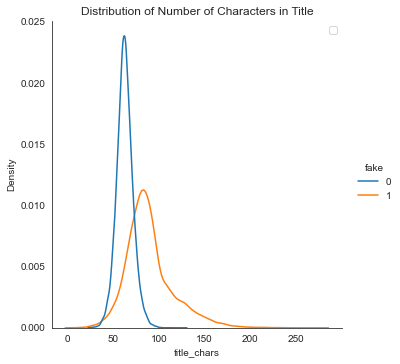

In [10]:
df['title_chars'] = df['title'].str.len()
sns.displot(df, x='title_chars', hue='fake', kind='kde')
plt.legend()
plt.title('Distribution of Number of Characters in Title')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Distribution of Number of Characters in Text')

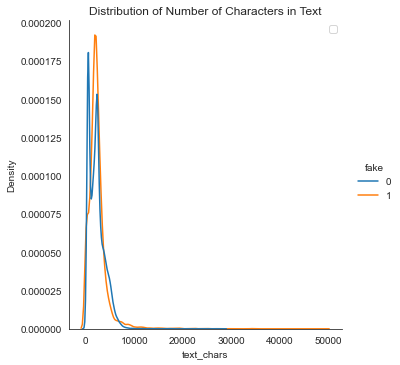

In [11]:
df['text_chars'] = df['text'].str.len()
sns.displot(df, x='text_chars', hue='fake', kind='kde')
plt.legend()
plt.title('Distribution of Number of Characters in Text')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Distribution of Number of Words in Title')

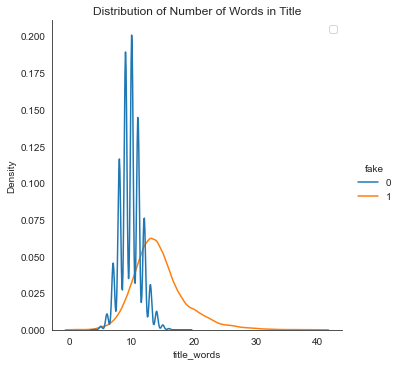

In [12]:
df['title_words'] = df['title'].str.split(' ').apply(len)
sns.displot(df, x='title_words', hue='fake', kind='kde')
plt.legend()
plt.title('Distribution of Number of Words in Title')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Distribution of Number of Words in Text')

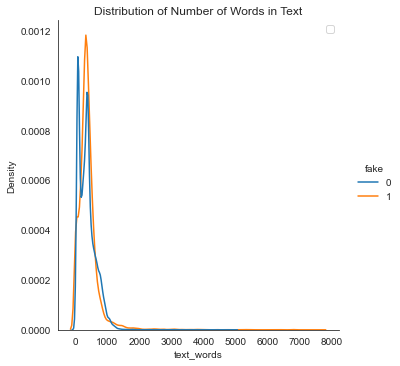

In [13]:
df['text_words'] = df['text'].str.split(' ').apply(len)
sns.displot(df, x='text_words', hue='fake', kind='kde')
plt.legend()
plt.title('Distribution of Number of Words in Text')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Distribution of Average Word Length in Text')

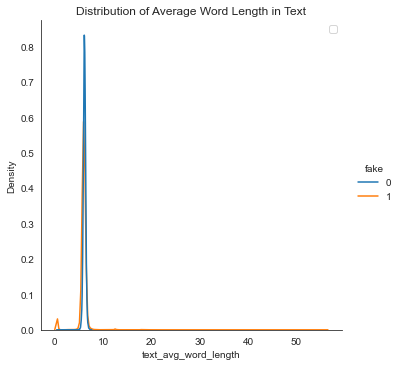

In [14]:
df['text_avg_word_length'] = df['text_chars'] / df['text_words']
sns.displot(df, x='text_avg_word_length', hue='fake', kind='kde')
plt.legend()
plt.title('Distribution of Average Word Length in Text')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Distribution of Average Sentence Length in Text')

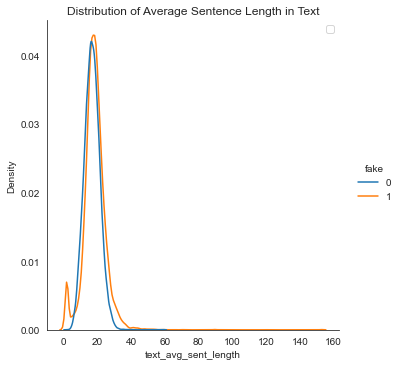

In [15]:
df['text_avg_sent_length'] = df['text_words'] / df['text_sentences']
sns.displot(df, x='text_avg_sent_length', hue='fake', kind='kde')
plt.legend()
plt.title('Distribution of Average Sentence Length in Text')

In [16]:
df.head()

title  \
0        As US budget fight looms Republicans flip their fiscal script   
1        US military to accept transgender recruits on Monday Pentagon   
2               Senior US Republican senator Let Mr Mueller do his job   
3            FBI Russia probe helped by Australian diplomat tipoff NYT   
4  Trump wants Postal Service to charge much more for Amazon shipments   

                                                                                                  text  \
0   The head of conservative Republican faction in the US Congress who voted this month for huge ex...   
1   Transgender people will be allowed for the first time to enlist in the US military starting on ...   
2   The special counsel investigation of links between Russia and President Trump election campaign...   
3   Trump campaign adviser George Papadopoulos told an Australian diplomat in May that Russia had p...   
4   President Donald Trump called on the US Postal Service on Friday to charge much more to ship pa...   

                 date  fake  text_sentences  \
0  December 31, 2017      0              50   
1  December 29, 2017      0              38   
2  December 31, 2017      0              23   
3  December 30, 2017      0              22   
4  December 29, 2017      0              59   

                                                                                              combined  \
0  As US budget fight looms Republicans flip their fiscal script  The head of conservative Republic...   
1  US military to accept transgender recruits on Monday Pentagon  Transgender people will be allowe...   
2  Senior US Republican senator Let Mr Mueller do his job  The special counsel investigation of lin...   
3  FBI Russia probe helped by Australian diplomat tipoff NYT  Trump campaign adviser George Papadop...   
4  Trump wants Postal Service to charge much more for Amazon shipments  President Donald Trump call...   

   title_chars  text_chars  title_words  text_words  text_avg_word_length  \
0           61        4389           10         710              6.181690   
1           61        3896            9         600              6.493333   
2           54        2662           10         445              5.982022   
3           57        2345            9         365              6.424658   
4           67        4891           11         812              6.023399   

   text_avg_sent_length  
0             14.200000  
1             15.789474  
2             19.347826  
3             16.590909  
4             13.762712

## Removing Stopwords
We create a new column with removed stopwords, but we won't remove these entirely yet as they may still be useful for feature engineering.

In [26]:
def remove_stopwords(text):
    tokenized = word_tokenize(text)
    return ' '.join([word for word in tokenized if word.lower() not in sw])

df['combined_no_sw'] = df['combined'].progress_apply(remove_stopwords)
df[['combined', 'combined_no_sw']].head()


100%|██████████| 44898/44898 [01:04<00:00, 700.54it/s]


combined  \
0  As US budget fight looms Republicans flip their fiscal script  The head of conservative Republic...   
1  US military to accept transgender recruits on Monday Pentagon  Transgender people will be allowe...   
2  Senior US Republican senator Let Mr Mueller do his job  The special counsel investigation of lin...   
3  FBI Russia probe helped by Australian diplomat tipoff NYT  Trump campaign adviser George Papadop...   
4  Trump wants Postal Service to charge much more for Amazon shipments  President Donald Trump call...   

                                                                                        combined_no_sw  
0  budget fight looms Republicans flip fiscal script head conservative Republican faction Congress ...  
1  military accept transgender recruits Monday Pentagon Transgender people allowed time enlist mili...  
2  Senior Republican senator Let Mr Mueller job special counsel investigation links Russia Presiden...  
3  FBI Russia probe helped Australian diplomat tipoff NYT Trump campaign adviser George Papadopoulo...  
4  Trump wants Postal Service charge Amazon shipments President Donald Trump called Postal Service ...

## Plotting the Most Common Words in Each Class

Text(0.5, 0.98, 'Freuqency of Most Common Words for Real and Fake Articles')

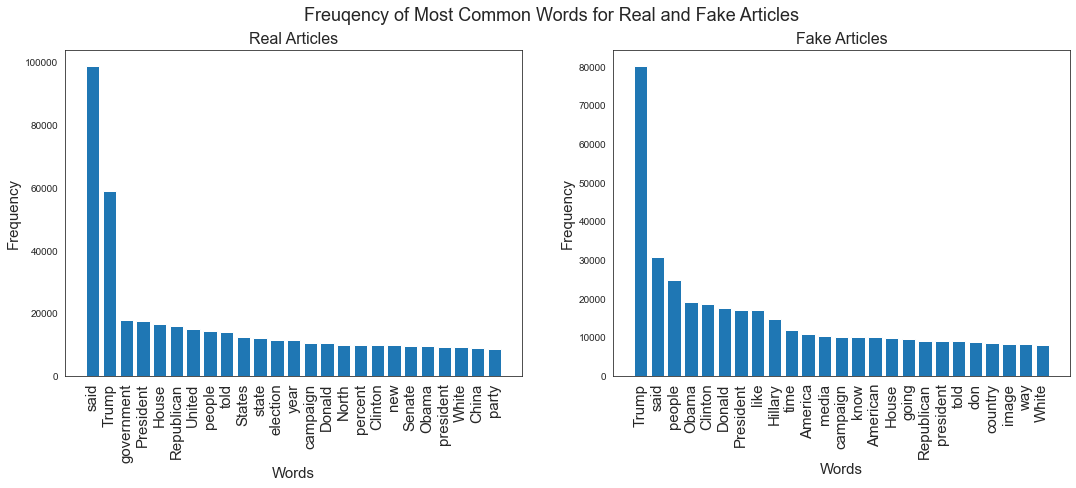

In [27]:
group_by_class = df.groupby('fake')['combined_no_sw'].apply(lambda x: Counter(' '.join(x).split()).most_common(25))
group_by_0 = group_by_class.iloc[0]
words_0 = list(zip(*group_by_0))[0]
freq_0 = list(zip(*group_by_0))[1]

group_by_1 = group_by_class.iloc[1]
words_1 = list(zip(*group_by_1))[0]
freq_1 = list(zip(*group_by_1))[1]

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
ax[0].bar(words_0, freq_0)
ax[0].set_xlabel('Words', fontsize=15)
ax[0].set_ylabel('Frequency', fontsize=15)
ax[0].tick_params(axis='x', labelsize=15, rotation=90)
ax[0].set_title('Real Articles', fontsize=16)

ax[1].bar(words_1, freq_1)
ax[1].set_xlabel('Words', fontsize=15)
ax[1].set_ylabel('Frequency', fontsize=15)
ax[1].tick_params(axis='x', labelsize=15, rotation=90)
ax[1].set_title('Fake Articles', fontsize=16)

plt.suptitle('Freuqency of Most Common Words for Real and Fake Articles', fontsize=18)

## Removing Skewed Words
The words 'said' and 'trump' are skewing the distributions. It may be a good idea to remove them. We'll append a new column, `text_no_skew` containing the text without these words.

In [28]:
df['combined_no_skew'] = df['combined_no_sw'].str.replace(
    r'[Tt]rump', '').str.replace(
    r'[Ss]aid', '').str.replace(
    '\s+', ' ').str.strip()
df.head()

title  \
0        As US budget fight looms Republicans flip their fiscal script   
1        US military to accept transgender recruits on Monday Pentagon   
2               Senior US Republican senator Let Mr Mueller do his job   
3            FBI Russia probe helped by Australian diplomat tipoff NYT   
4  Trump wants Postal Service to charge much more for Amazon shipments   

                                                                                                  text  \
0   The head of conservative Republican faction in the US Congress who voted this month for huge ex...   
1   Transgender people will be allowed for the first time to enlist in the US military starting on ...   
2   The special counsel investigation of links between Russia and President Trump election campaign...   
3   Trump campaign adviser George Papadopoulos told an Australian diplomat in May that Russia had p...   
4   President Donald Trump called on the US Postal Service on Friday to charge much more to ship pa...   

                 date  fake  text_sentences  \
0  December 31, 2017      0              50   
1  December 29, 2017      0              38   
2  December 31, 2017      0              23   
3  December 30, 2017      0              22   
4  December 29, 2017      0              59   

                                                                                              combined  \
0  As US budget fight looms Republicans flip their fiscal script  The head of conservative Republic...   
1  US military to accept transgender recruits on Monday Pentagon  Transgender people will be allowe...   
2  Senior US Republican senator Let Mr Mueller do his job  The special counsel investigation of lin...   
3  FBI Russia probe helped by Australian diplomat tipoff NYT  Trump campaign adviser George Papadop...   
4  Trump wants Postal Service to charge much more for Amazon shipments  President Donald Trump call...   

   title_chars  text_chars  title_words  text_words  text_avg_word_length  \
0           61        4389           10         710              6.181690   
1           61        3896            9         600              6.493333   
2           54        2662           10         445              5.982022   
3           57        2345            9         365              6.424658   
4           67        4891           11         812              6.023399   

   text_avg_sent_length  \
0             14.200000   
1             15.789474   
2             19.347826   
3             16.590909   
4             13.762712   

                                                                                        combined_no_sw  \
0  budget fight looms Republicans flip fiscal script head conservative Republican faction Congress ...   
1  military accept transgender recruits Monday Pentagon Transgender people allowed time enlist mili...   
2  Senior Republican senator Let Mr Mueller job special counsel investigation links Russia Presiden...   
3  FBI Russia probe helped Australian diplomat tipoff NYT Trump campaign adviser George Papadopoulo...   
4  Trump wants Postal Service charge Amazon shipments President Donald Trump called Postal Service ...   

                                                                                      combined_no_skew  \
0  budget fight looms Republicans flip fiscal script head conservative Republican faction Congress ...   
1  military accept transgender recruits Monday Pentagon Transgender people allowed time enlist mili...   
2  Senior Republican senator Let Mr Mueller job special counsel investigation links Russia Presiden...   
3  FBI Russia probe helped Australian diplomat tipoff NYT Trump campaign adviser George Papadopoulo...   
4  Trump wants Postal Service charge Amazon shipments President Donald Trump called Postal Service ...   

   sentiment  
0   0.037083  
1   0.051296  
2   0.115930  
3   0.034969  
4   0.039806

## Sentiment Analysis

In [30]:
df['sentiment'] = df['combined'].progress_apply(lambda x: TextBlob(x).sentiment.polarity)
group_by_class_sentiment = df.groupby('fake')['sentiment']


100%|██████████| 44898/44898 [01:15<00:00, 592.24it/s]


Text(0.5, 1.0, 'Real vs. Fake Article Sentiment Distribution')

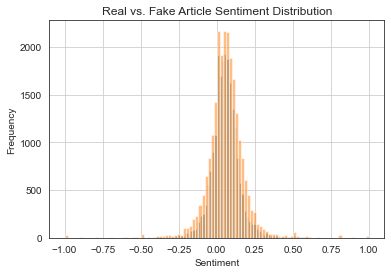

In [31]:
group_by_class_sentiment.hist(alpha=0.5, bins=100)
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Real vs. Fake Article Sentiment Distribution')

In [32]:
group_by_class_sentiment.skew()

fake
0    0.286839
1   -0.328604
Name: sentiment, dtype: float64

The real/true articles have more of a positive sentiment skew than the fake articles.

In [33]:
sentiment_correlation = df[
                           ['fake', 'sentiment', 'text_chars', 'text_words']
                           ].corr()
mask = np.zeros_like(sentiment_correlation, dtype=bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10, 8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.title('Class Correlation with Length and Sentiment', fontsize=20)
sns.heatmap(sentiment_correlation, 
            cmap='coolwarm', annot=True, annot_kws={'size': 20}, 
            linewidths=5, vmin=-1.0, mask=mask)

<AxesSubplot:title={'center':'Class Correlation with Length and Sentiment'}>

## Removed Named Entities

In [34]:
def remove_named_entities(text):
    doc = nlp(text)
    text_no_names = []
    ents = [e.text for e in doc.ents if e.label_ in ['PERSON', 'ORG', 'GPE']]
    ents = ' '.join(ents).split(' ')
    for item in doc:
        if item.text in ents:
            pass
        else:
            text_no_names.append(item.text)
  
    return ' '.join(text_no_names)

df['combined_no_names'] = df['combined_no_skew'].progress_apply(remove_named_entities)
df.head()


100%|██████████| 44898/44898 [21:05<00:00, 35.49it/s]


title  \
0        As US budget fight looms Republicans flip their fiscal script   
1        US military to accept transgender recruits on Monday Pentagon   
2               Senior US Republican senator Let Mr Mueller do his job   
3            FBI Russia probe helped by Australian diplomat tipoff NYT   
4  Trump wants Postal Service to charge much more for Amazon shipments   

                                                                                                  text  \
0   The head of conservative Republican faction in the US Congress who voted this month for huge ex...   
1   Transgender people will be allowed for the first time to enlist in the US military starting on ...   
2   The special counsel investigation of links between Russia and President Trump election campaign...   
3   Trump campaign adviser George Papadopoulos told an Australian diplomat in May that Russia had p...   
4   President Donald Trump called on the US Postal Service on Friday to charge much more to ship pa...   

                 date  fake  text_sentences  \
0  December 31, 2017      0              50   
1  December 29, 2017      0              38   
2  December 31, 2017      0              23   
3  December 30, 2017      0              22   
4  December 29, 2017      0              59   

                                                                                              combined  \
0  As US budget fight looms Republicans flip their fiscal script  The head of conservative Republic...   
1  US military to accept transgender recruits on Monday Pentagon  Transgender people will be allowe...   
2  Senior US Republican senator Let Mr Mueller do his job  The special counsel investigation of lin...   
3  FBI Russia probe helped by Australian diplomat tipoff NYT  Trump campaign adviser George Papadop...   
4  Trump wants Postal Service to charge much more for Amazon shipments  President Donald Trump call...   

   title_chars  text_chars  title_words  text_words  text_avg_word_length  \
0           61        4389           10         710              6.181690   
1           61        3896            9         600              6.493333   
2           54        2662           10         445              5.982022   
3           57        2345            9         365              6.424658   
4           67        4891           11         812              6.023399   

   text_avg_sent_length  \
0             14.200000   
1             15.789474   
2             19.347826   
3             16.590909   
4             13.762712   

                                                                                        combined_no_sw  \
0  budget fight looms Republicans flip fiscal script head conservative Republican faction Congress ...   
1  military accept transgender recruits Monday Pentagon Transgender people allowed time enlist mili...   
2  Senior Republican senator Let Mr Mueller job special counsel investigation links Russia Presiden...   
3  FBI Russia probe helped Australian diplomat tipoff NYT Trump campaign adviser George Papadopoulo...   
4  Trump wants Postal Service charge Amazon shipments President Donald Trump called Postal Service ...   

                                                                                      combined_no_skew  \
0  budget fight looms Republicans flip fiscal script head conservative Republican faction Congress ...   
1  military accept transgender recruits Monday Pentagon Transgender people allowed time enlist mili...   
2  Senior Republican senator Let Mr Mueller job special counsel investigation links Russia Presiden...   
3  FBI Russia probe helped Australian diplomat tipoff NYT Trump campaign adviser George Papadopoulo...   
4  Trump wants Postal Service charge Amazon shipments President Donald Trump called Postal Service ...   

   sentiment  \
0   0.037083   
1   0.051296   
2   0.115930   
3   0.034969   
4   0.039806   

                                                                  

In [35]:
df_preprocessed_real = df[df['fake'] == 0]
df_preprocessed_fake = df[df['fake'] == 1]

In [36]:
text_cols = list(df_preprocessed_real.select_dtypes(object).columns)
text_cols.remove('date')

df_preprocessed_real[text_cols] = df_preprocessed_real[text_cols].apply(lambda x: x.str.lower())
df_preprocessed_fake[text_cols] = df_preprocessed_fake[text_cols].apply(lambda x: x.str.lower())

df_preprocessed_real.to_csv('data/df_preprocessed_real.csv')
df_preprocessed_fake.to_csv('data/df_preprocessed_fake.csv')